### Imports

In [1]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain.messages import HumanMessage, SystemMessage
from langgraph.types import Send
from typing import Annotated, List, Dict
import operator
from IPython.display import Markdown
from datetime import datetime

### Initialize the LLM

In [2]:
load_dotenv()

groq_key = os.getenv("groq_api_key")
os.environ["GROQ_API_KEY"] = groq_key

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0
)

In [3]:
# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(description="Name for this section of the report.",)
    description: str = Field(description="Brief overview of the main topics and concepts to be covered in this section.",)


class Sections(BaseModel):
    sections: List[Section] = Field(description="Sections of the report.",)


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

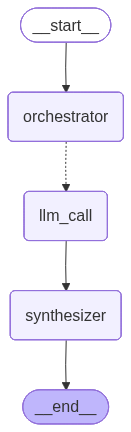

In [5]:
# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    section_start_time: Annotated[Dict[str, str], operator.or_]
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    now = datetime.now()
    current_time_string = now.strftime("%H:%M:%S")

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"section_start_time": {state['section'].name: current_time_string}, "completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Save the workflow as image
# orchestrator_worker.get_graph().draw_mermaid_png(output_file_path="orchestrator_worker_flow.png")

In [6]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

Markdown(state["final_report"])

### Introduction and Description
#### Overview of the Report
This report provides an in-depth examination of the current state of Large Language Models (LLMs) and the significance of scaling laws in their development. LLMs have revolutionized the field of natural language processing, enabling applications such as language translation, text summarization, and chatbots. The report delves into the concept of scaling laws, which refer to the relationships between model size, computational resources, and performance metrics.

#### Importance of LLM Scaling Laws
LLM scaling laws are crucial for understanding how to efficiently develop and deploy large language models. By identifying the optimal balance between model size, computational resources, and performance, researchers and developers can create more effective and efficient LLMs. The importance of scaling laws lies in their ability to:
* **Predict performance**: Scaling laws allow developers to predict the performance of LLMs based on their size and computational resources.
* **Optimize resources**: By understanding the relationships between model size, computational resources, and performance, developers can optimize resource allocation and reduce costs.
* **Improve model design**: Scaling laws provide insights into the design of LLMs, enabling developers to create more efficient and effective models.
* **Advance research**: The study of scaling laws contributes to the advancement of research in natural language processing, enabling the development of more sophisticated and powerful LLMs.

---

### Background and description: History and development of large language models (LLMs) and their applications
#### Introduction to LLMs
Large Language Models (LLMs) have undergone significant transformations since their inception, evolving from basic language processing tools to sophisticated systems capable of understanding, generating, and interacting with human language at an unprecedented level. The history of LLMs is marked by continuous advancements in computational power, algorithmic innovations, and the availability of vast amounts of training data.

#### Early Developments
The early developments in LLMs can be traced back to the 1950s, with the Dartmouth Summer Research Project on Artificial Intelligence, where the term "Artificial Intelligence" was coined. However, it wasn't until the 1980s and 1990s that neural networks began to be explored for natural language processing tasks. These early models were limited by the computational resources and data available at the time.

#### Modern Era
The modern era of LLMs began to take shape with the introduction of deep learning techniques and the availability of large datasets. Models like Word2Vec (2013) and GloVe (2014) introduced vector space representations of words, allowing for more nuanced understanding and generation of text. The subsequent development of transformer models, such as BERT (2018) and its successors, revolutionized the field by achieving state-of-the-art results in a wide range of natural language processing tasks.

#### Applications of LLMs
LLMs have found applications in numerous areas, including but not limited to:
- **Text Generation**: LLMs can create coherent and contextually appropriate text, useful for content creation, chatbots, and automated writing tools.
- **Language Translation**: By understanding the nuances of language, LLMs can translate text from one language to another with high accuracy.
- **Sentiment Analysis**: They can analyze text to determine the sentiment or emotional tone behind it, useful for market research and social media monitoring.
- **Question Answering**: LLMs can process natural language questions and provide relevant answers, making them useful for search engines and virtual assistants.
- **Content Summarization**: They can summarize long pieces of content into concise, meaningful summaries, saving time and effort for readers.

#### Future Directions
As LLMs continue to evolve, future directions include improving their ability to understand context, common sense, and multimodal inputs (like images and audio). There is also a growing focus on making LLMs more transparent, explainable, and aligned with human values to ensure their safe and beneficial deployment in society.

---

### Scaling Laws
Scaling laws refer to the empirical observations that the performance of large language models (LLMs) improves as the size of the model and the amount of training data increase. These laws describe the relationship between the model's size, training data, and computational resources, and its resulting performance on various natural language processing (NLP) tasks.

#### Types of Scaling Laws
There are several types of scaling laws that have been observed in LLM development, including:
* **Compute scaling**: The amount of computational resources required to train a model increases with the size of the model and the amount of training data.
* **Data scaling**: The amount of training data required to achieve a certain level of performance increases with the size of the model.
* **Model size scaling**: The performance of a model improves as the number of parameters in the model increases.

#### Role in LLM Development
Scaling laws play a crucial role in LLM development as they provide a framework for understanding how to improve the performance of these models. By understanding the relationships between model size, training data, and computational resources, developers can:
* **Optimize training procedures**: Scaling laws can inform the design of training procedures, such as the choice of batch size, sequence length, and number of training steps.
* **Predict performance**: Scaling laws can be used to predict the performance of a model on a given task, allowing developers to estimate the resources required to achieve a certain level of performance.
* **Guide model architecture design**: Scaling laws can inform the design of model architectures, such as the choice of number of layers, hidden size, and attention mechanisms.

---

### Empirical Evidence
#### Introduction to Empirical Evidence
Empirical evidence plays a crucial role in understanding the existence of scaling laws in Large Language Models (LLMs). The concept of scaling laws suggests that the performance of LLMs improves predictably as the model size, dataset size, or compute budget increases. This section presents empirical evidence supporting the existence of scaling laws in LLMs.

#### Model Size and Performance
Studies have shown that as the model size increases, the performance of LLMs improves consistently. For example, a study on the scaling of transformer models found that the test loss decreases as the model size increases, following a power-law relationship. This relationship holds across different model architectures and datasets, providing strong evidence for the existence of scaling laws.

#### Dataset Size and Performance
The size of the training dataset also has a significant impact on the performance of LLMs. Empirical evidence suggests that the performance of LLMs improves as the dataset size increases, following a logarithmic relationship. This means that larger datasets lead to better performance, but the returns diminish as the dataset size increases.

#### Compute Budget and Performance
The compute budget, which refers to the amount of computational resources available for training, also affects the performance of LLMs. Empirical evidence shows that the performance of LLMs improves as the compute budget increases, following a power-law relationship. This means that increasing the compute budget leads to significant improvements in performance, especially for larger models.

#### Cross-Validation of Scaling Laws
Cross-validation of scaling laws across different models, datasets, and compute budgets provides further evidence for their existence. Studies have shown that scaling laws hold across different LLM architectures, including transformer-based models and recurrent neural network-based models. Additionally, scaling laws have been observed to hold across different datasets, including natural language processing datasets and computer vision datasets.

#### Implications of Empirical Evidence
The empirical evidence presented in this section has significant implications for the development and training of LLMs. It suggests that increasing the model size, dataset size, or compute budget can lead to significant improvements in performance, following predictable scaling laws. This knowledge can be used to inform the design of LLMs and the allocation of computational resources, leading to more efficient and effective training of these models.

---

### Theoretical Frameworks
#### Introduction to Theoretical Frameworks
Theoretical frameworks provide a foundation for understanding the scaling laws of Large Language Models (LLMs). These frameworks offer a structured approach to analyzing the relationships between model size, computational resources, and performance.

#### Power Law Scaling
One prominent framework is the power law scaling hypothesis, which suggests that the performance of LLMs improves according to a power law relationship with the model size. This framework is based on the idea that as the model size increases, the number of parameters and the complexity of the model grow, leading to improved performance.

#### Information-Theoretic Frameworks
Information-theoretic frameworks provide an alternative perspective on LLM scaling laws. These frameworks view LLMs as devices that process and transmit information, and they provide a theoretical foundation for understanding the limits of LLM performance. Information-theoretic frameworks can be used to derive bounds on the performance of LLMs and to identify the fundamental limits of scaling.

#### Computational Complexity Frameworks
Computational complexity frameworks focus on the computational resources required to train and deploy LLMs. These frameworks provide a theoretical foundation for understanding the trade-offs between model size, computational resources, and performance. Computational complexity frameworks can be used to analyze the scalability of LLMs and to identify opportunities for optimization.

#### Cognitive Architectures
Cognitive architectures provide a framework for understanding the cognitive processes that underlie LLM performance. These frameworks view LLMs as cognitive systems that process and generate language, and they provide a theoretical foundation for understanding the relationships between language processing, cognition, and performance. Cognitive architectures can be used to analyze the limitations and biases of LLMs and to identify opportunities for improvement.

#### Implications for LLM Scaling Laws
Theoretical frameworks have significant implications for our understanding of LLM scaling laws. By providing a structured approach to analyzing the relationships between model size, computational resources, and performance, theoretical frameworks can help to identify the fundamental limits of scaling and to optimize the performance of LLMs. Furthermore, theoretical frameworks can be used to analyze the limitations and biases of LLMs and to identify opportunities for improvement.

---

### Implications and Applications
#### Introduction to Implications
The discovery and understanding of LLM scaling laws have significant implications for the development and application of large language models. As these models continue to grow in size and complexity, it is essential to consider the potential consequences of their increasing capabilities. 
#### Potential Applications
Some potential applications of LLM scaling laws include:
* **Improved model efficiency**: By understanding how model performance scales with size, developers can create more efficient models that achieve better results with fewer parameters.
* **Specialized models**: Scaling laws can inform the development of specialized models designed for specific tasks or domains, leading to more effective and targeted language understanding.
* **Explainability and transparency**: Analyzing scaling laws can provide insights into how models make predictions, enabling the development of more explainable and transparent AI systems.
* **Ethical considerations**: As LLMs become more powerful, it is crucial to consider the potential ethical implications of their use, such as bias, misinformation, and job displacement.
#### Future Directions
The study of LLM scaling laws is an active area of research, and future work may focus on:
* **Investigating scaling laws in other AI domains**: Applying the principles of scaling laws to other areas of AI, such as computer vision or reinforcement learning, could lead to breakthroughs in those fields.
* **Developing more accurate scaling laws**: Refining our understanding of scaling laws can help developers create more effective models and improve the overall performance of LLMs.
* **Addressing potential risks and challenges**: As LLMs continue to evolve, it is essential to address potential risks and challenges, such as ensuring the security and reliability of these models.

---

### Conclusion
The study of LLM scaling laws has yielded significant insights into the complex relationships between model size, computational resources, and performance. Key findings include:
* **Power-law relationships**: The existence of power-law relationships between model size and performance metrics, such as perplexity and accuracy.
* **Scaling exponents**: The identification of distinct scaling exponents for different model architectures and tasks, highlighting the importance of architecture and task-specific design choices.
* **Computational requirements**: The exponential growth of computational requirements with model size, emphasizing the need for efficient training methods and specialized hardware.
* **Emergence of new capabilities**: The observation that larger models exhibit new capabilities, such as improved few-shot learning and reasoning, which are not present in smaller models.

Future directions for research on LLM scaling laws include:
* **Investigating the limits of scaling**: Exploring the theoretical and practical limits of scaling laws, including the potential for diminishing returns or phase transitions.
* **Developing more efficient training methods**: Designing novel training algorithms and techniques that can mitigate the exponential growth of computational requirements.
* **Examining the role of architecture**: Investigating the interplay between model architecture and scaling laws, including the potential for architecture-specific scaling laws.
* **Applying scaling laws to real-world applications**: Translating the insights gained from scaling law research into practical improvements for real-world NLP applications, such as language translation, question answering, and text generation.

In [7]:
state

{'topic': 'Create a report on LLM scaling laws',
 'sections': [Section(name='Introduction', description='Overview of the report and the importance of LLM scaling laws'),
  Section(name='Background', description='History and development of large language models (LLMs) and their applications'),
  Section(name='Scaling Laws', description='Explanation of the concept of scaling laws and their role in LLM development'),
  Section(name='Empirical Evidence', description='Presentation of empirical evidence supporting the existence of scaling laws in LLMs'),
  Section(name='Theoretical Frameworks', description='Discussion of theoretical frameworks for understanding LLM scaling laws'),
  Section(name='Implications and Applications', description='Exploration of the implications and potential applications of LLM scaling laws'),
  Section(name='Conclusion', description='Summary of key findings and future directions for research on LLM scaling laws')],
 'completed_sections': ['### Introduction and De

In [8]:
# Stream
for node in orchestrator_worker.stream({"topic": "Create a report on LLM scaling laws"}):
    print(node)

{'orchestrator': {'sections': [Section(name='Introduction', description='Overview of the report and the importance of LLM scaling laws'), Section(name='Background', description='History and development of large language models (LLMs) and their applications'), Section(name='Scaling Laws', description='Explanation of the concept of scaling laws and their role in LLM development'), Section(name='Empirical Evidence', description='Presentation of empirical evidence supporting the existence of scaling laws in LLMs'), Section(name='Theoretical Frameworks', description='Discussion of theoretical frameworks for understanding LLM scaling laws'), Section(name='Implications and Applications', description='Exploration of the implications and potential applications of LLM scaling laws'), Section(name='Conclusion', description='Summary of key findings and future directions for research on LLM scaling laws')]}}
{'llm_call': {'section_start_time': {'Conclusion': '14:36:12'}, 'completed_sections': ['###

In [9]:
# Stream
for node in orchestrator_worker.stream({"topic": "Create a report on LLM scaling laws"}):
    if 'orchestrator' in node:
        for i, section in enumerate(node['orchestrator']['sections']):
            print(i+1, section)
        print("-"*10)
    else:
        print(node)

1 name='Introduction' description='Overview of the report and the importance of LLM scaling laws'
2 name='Background' description='History and development of LLMs and their scaling laws'
3 name='Scaling Laws' description='In-depth explanation of the different types of scaling laws for LLMs, including parameter, data, and compute scaling laws'
4 name='Applications and Implications' description='Discussion of the applications and implications of LLM scaling laws, including their impact on AI research and industry'
5 name='Conclusion' description='Summary of key findings and future directions for LLM scaling laws research'
----------
{'llm_call': {'section_start_time': {'Introduction': '14:36:54'}, 'completed_sections': ['### Introduction and Description\n#### Overview of the Report\nThis report provides an in-depth examination of the current state of Large Language Models (LLMs) and the significance of scaling laws in their development. LLMs have revolutionized the field of natural langu